In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import pickle
import sys 

path = '/low_rank'

sys.path.append(path)

In [2]:
data = pickle.load(open('/movie_tables.pkl','rb'))
ratings_df = data['ratings_df']
ratings_val_df = data['ratings_val_df']
ratings_test_df = data['ratings_test_df']
val_keep = (ratings_val_df['userId'].isin(ratings_df['userId'])) & (ratings_val_df['movieId'].isin(ratings_df['movieId']))
test_keep = (ratings_test_df['userId'].isin(ratings_df['userId'])) & (ratings_test_df['movieId'].isin(ratings_df['movieId']))
ratings_val_df = ratings_val_df[val_keep]
ratings_test_df = ratings_test_df[test_keep]



In [14]:
from typing import Optional
from scipy.stats import rv_discrete
from util import rectangular_partition_train_val_test
from netflix import solver_params, wrap_experiments

full_df = pd.concat([ratings_df, ratings_val_df, ratings_test_df], axis=0)
R = coo_matrix((full_df['rating'], (full_df['userId'],full_df['movieId'])))
R = np.asarray(R.todense())

train_p = .5
val_p = .3
n_row = R.shape[0]
n_col = R.shape[1]
Omegas = rectangular_partition_train_val_test(n_row, n_col, train_p, val_p)

X = (R > 0).astype(float)

p_solvers = solver_params()
print(len(p_solvers))

wrap_experiments(X, Omegas, p_solvers)
#wrap_experiments(X, Omegas, p_solvers[:3])



  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

12




 33%|███▎      | 1/3 [02:18<04:37, 138.76s/it]


 33%|███▎      | 1/3 [02:18<04:37, 138.75s/it]

 67%|██████▋   | 2/3 [04:37<02:18, 138.76s/it]


 67%|██████▋   | 2/3 [04:37<02:18, 138.76s/it]

100%|██████████| 3/3 [06:56<00:00, 138.74s/it]


100%|██████████| 3/3 [06:56<00:00, 138.74s/it]


['netflix_logistic_v5.solver_5_0.003000_200_0.010000_0',
 'netflix_logistic_v5.solver_5_0.003000_200_0.010000_1',
 'netflix_logistic_v5.solver_5_0.001000_200_0.010000_0']

In [16]:
from itertools import product

from tqdm import tqdm
from util import load_obj
#netflix_logistic_v3.solver_5_0.001000_200_0.010000_0_obj.pkl
Res = {}
for apsolver in tqdm(p_solvers):
    name = "_".join(['netflix_logistic', apsolver._str()])
    Res[apsolver] = load_obj(name)




  0%|          | 0/12 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 53.60it/s]


In [17]:
import pandas as pd
from mc import GDSolverParam
import numpy as np
import matplotlib.pyplot as plt


def to_frame(_psolver, _res, idx_tag="0"):
    _res = _res.copy()
    _res.pop("U")
    _res.pop("V")
    _res.pop('test_top')
    _df = pd.DataFrame(_res)
    stat_cols = list(_df.columns)
    _df["estk"] = _psolver.estk
    _df["lr"] = _psolver.lr
    _df["scale_init"] = _psolver.scale_init
    _df["seed"] = _psolver.random_seed
    _df["idx_tag"] = idx_tag
    _df["iters"] = list(range(_df.shape[0]))
    solver_cols = ["estk", "lr", "scale_init", "iters", "seed"]
    cols = solver_cols + stat_cols + ["idx_tag"]
    return _df[cols]



def build_opt_p(use_solvers, res_map):
    df_m = pd.concat(
        [
            to_frame(aps, res_map[aps], i)
            for i, aps in tqdm(enumerate(use_solvers), disable=True)
        ],
        axis=0,
        ignore_index=True,
    )

    # find the optimal one
    df_m = df_m[df_m["iters"] % 10 == 9]
    #idx = df_m["val_loss"].argmin()
    idx = df_m["val_loss"].argmin()
    res = {}
    res2 = {
        "estk": df_m.iloc[idx, :].estk,
        "lr": df_m.iloc[idx, :].lr,
        "scale_init": df_m.iloc[idx, :].scale_init,
        "train_loss": df_m.iloc[idx, :].train_loss,
        "train_misclass": df_m.iloc[idx, :].train_misclassify,
        'val_loss': df_m.iloc[idx, :].val_loss,
        'val_misclass': df_m.iloc[idx, :].val_misclassify,
        'test_loss': df_m.iloc[idx, :].test_loss,
        'test_misclass': df_m.iloc[idx, :].test_misclassify,
        "seed": df_m.iloc[idx, :].seed,
        "iters": df_m.iloc[idx, :].iters,
        "n_iter": 200,
    }

    # find the result using the last iteration.
    idx_tag = df_m.iloc[idx, :].idx_tag
    stopped_cor = df_m[df_m.idx_tag == idx_tag].iloc[-1, :].test_loss
    if stopped_cor < 0 or stopped_cor <= df_m.iloc[idx, :].test_loss * 0.9:
        res2["early_stop"] = True
    else:
        res2["early_stop"] = False

    res.update(res2)
    rrr = pd.DataFrame(res, index=[0])

    use_solver = GDSolverParam(
        estk=res2["estk"],
        lr=res2["lr"],
        scale_init=res2["scale_init"],
        n_iter=res2["n_iter"],
        random_seed=res2["seed"],
    )
    use_iter = int(df_m.iloc[idx, :].iters)

    useU = Res[use_solver]["U"][use_iter // 10]
    useV = Res[use_solver]["V"][use_iter // 10]
    
    estG = useU @ useV.T
    
    avg_estG = estG.copy()
    solvers_with_other_seeds = [
        GDSolverParam(
            estk=res2["estk"],
            lr=res2["lr"],
            scale_init=res2["scale_init"],
            n_iter=res2["n_iter"],
            random_seed=i,
        )
        for i in range(2)
        if i != res2["seed"]
    ]
    all_cors = []
    all_pred_corr = []
    ii = 1
    
    for tmp in solvers_with_other_seeds:
        if tmp in Res:
            all_cors.append(Res[tmp]["test_loss"][use_iter])
            nextU = Res[tmp]["U"][use_iter // 10]
            nextV = Res[tmp]["V"][use_iter // 10]
            nextG = nextU@(nextV.T)
            avg_estG += nextG
            ii += 1
            predcor = np.corrcoef((nextG).reshape(-1), estG.reshape(-1))
            all_pred_corr.append(predcor[0, 1])

    mean_corr = np.mean(all_cors)
    mean_predcorr = np.mean(all_pred_corr)
    
    rrr["mean_loss"] = mean_corr
    rrr["pred_corr"] = mean_predcorr
    #rrr['improved_corr'] = np.corrcoef(raw_data['latent'].reshape(-1), avg_estG.reshape(-1))[0, 1]
    return rrr



res = Res[p_solvers[0]]
dft = to_frame(p_solvers[0], res)


  0%|          | 0/6 [10:55<?, ?it/s]


In [18]:
use_solvers = [p_solver for p_solver in p_solvers if p_solver.random_seed == 0]

df_merged = pd.concat([build_opt_p([solver], Res) for solver in tqdm(use_solvers)], axis=0)
df_merged


100%|██████████| 6/6 [00:00<00:00, 12.01it/s]


,estk,lr,scale_init,train_loss,train_misclass,val_loss,val_misclass,test_loss,test_misclass,seed,iters,n_iter,early_stop,mean_loss,pred_corr
0,5.0,0.003,0.01,0.697086,0.019217,0.698798,0.022961,0.698797,0.023018,0.0,179.0,200,False,0.698690,0.959989
0,5.0,0.001,0.01,0.700395,0.022707,0.700702,0.023246,0.700732,0.023264,0.0,199.0,200,False,0.700625,0.945265
0,10.0,0.003,0.01,0.694192,0.014728,0.698137,0.024096,0.698162,0.023674,0.0,199.0,200,False,0.698148,0.930769
0,10.0,0.001,0.01,0.700019,0.022085,0.700437,0.023301,0.700531,0.022781,0.0,199.0,200,False,0.700343,0.997672
0,100.0,0.003,0.01,0.687007,0.002225,0.695761,0.022971,0.695816,0.022456,0.0,199.0,200,False,0.695820,0.960628
0,100.0,0.001,0.01,0.698442,0.019851,0.699501,0.022661,0.699617,0.022388,0.0,199.0,200,False,0.699612,0.999750


In [19]:
print(df_merged[['estk', 'lr', 'train_loss', 'test_loss', 'test_misclass']].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   estk &     lr &  train\_loss &  test\_loss &  test\_misclass \\
\midrule
0 &    5.0 &  0.003 &    0.697086 &   0.698797 &       0.023018 \\
0 &    5.0 &  0.001 &    0.700395 &   0.700732 &       0.023264 \\
0 &   10.0 &  0.003 &    0.694192 &   0.698162 &       0.023674 \\
0 &   10.0 &  0.001 &    0.700019 &   0.700531 &       0.022781 \\
0 &  100.0 &  0.003 &    0.687007 &   0.695816 &       0.022456 \\
0 &  100.0 &  0.001 &    0.698442 &   0.699617 &       0.022388 \\
\bottomrule
\end{tabular}



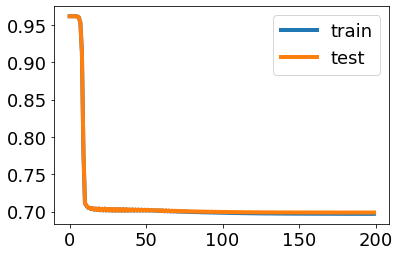

In [20]:
fontsize=18
plt.plot(Res[p_solvers[0]]['train_loss'], label='train', linewidth=4)
plt.plot(Res[p_solvers[0]]['test_loss'], label='test', linewidth=4)
plt.legend(loc="upper right", fontsize=fontsize )
plt.tick_params(axis="both", which="major", labelsize=fontsize)
plt.savefig('logistic.png')